In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

data_100k = 'ml-100k/u.data'

In [2]:
def cosSimilarity(matrix):
    similarity_matrix = cosine_similarity(matrix)
    print("Cosine Similarity Matrix Sample:")
    print(similarity_matrix[:5, :5])
    print("=" * 120)
    return similarity_matrix

In [3]:
# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs,person1,person2):
    # Get the list of shared_items
    si={}
    for item in prefs[person1]: 
        if item in prefs[person2]: si[item]=1

    # if they have no ratings in common, return 0
    if len(si)==0: return 0

    # Add up the squares of all the differences
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2) 
                        for item in prefs[person1] if item in prefs[person2]])

    return 1/(1+sum_of_squares)

In [4]:
# Returns the Pearson correlation coefficient for p1 and p2
def sim_pearson(prefs,p1,p2):
    # Get the list of mutually rated items
    si={}
    for item in prefs[p1]: 
        if item in prefs[p2]: si[item]=1

    # if they are no ratings in common, return 0
    if len(si)==0: return 0

    # Sum calculations
    n=len(si)
    
    # Sums of all the preferences
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])
    
    # Sums of the squares
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si]) 
    
    # Sum of the products
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])
    
    # Calculate r (Pearson score)
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=num/den

    return r

In [5]:
def loadData(test_size=0.2, datafile='ml-100k/u.data', header=['uid','iid','ratings','timestamp'], sep='\t', seed=0):
    # Read CSV File into A Pandas DataFrame
    df = pd.read_csv(datafile, header=None, names=header, sep=sep, engine='python')
    df.drop(columns='timestamp')
    print(df.head())
    # The Number of User and Items
    num_users, num_items = df[header[0]].unique().shape[0], df[header[1]].unique().shape[0]
    # The minimum id of user and item (because in Python array index is from 0)
    uid_min, iid_min = df['uid'].min(), df['iid'].min()

    # Train and Test Dataset Splitting
    train_df, test_df = train_test_split(np.asarray(df), test_size=test_size, random_state=seed)

    # Change the data structure into sparse matrix
    train = sp.csr_matrix((train_df[:, 2], (train_df[:, 0]-uid_min, train_df[:, 1]-iid_min)), shape=(num_users, num_items))
    test = sp.csr_matrix((test_df[:, 2], (test_df[:, 0]-uid_min, test_df[:, 1]-iid_min)), shape=(num_users, num_items))

    print("Number of Users: " + str(num_users))
    print("Number of Items: " + str(num_items))
    print("=" * 120)

    print("Sample Data: " + str(train.getrow(0).toarray()))
    print("=" * 120)

    return train, test


# def loadData(test_size=0.2, datafile='ml-100k/u.data', header=['uid','iid','ratings','timestamp'], sep='\t', seed=0):
#     # Read CSV File into A Pandas DataFrame
#     df = pd.read_csv(datafile, header=None, names=header, sep=sep, engine='python')
#     df = df.drop(columns='timestamp')
#     print(df.head())
#     # The Number of User and Items
#     num_users, num_items = df[header[0]].unique().shape[0], df[header[1]].unique().shape[0]
#     # The minimum id of user and item (because in Python array index is from 0)
#     uid_min, iid_min = df['uid'].min(), df['iid'].min()
#     uid_max, iid_max = df['uid'].max(), df['iid'].max()
# #     print(uid_max,iid_max)
# #     print(num_users)
#     result = np.zeros((num_users, num_items))
#     for index, row in df.iterrows():
#         result[int(row['uid'])-1,int(row['iid'])-1] = int(row['ratings'])
#     train, test = train_test_split(result, test_size=test_size, random_state = seed)
#     return train, test

In [6]:
def Precision_and_Recall(pred_item_list, test_item_list):
    # Calculate the Number of Occurrences of Testing Item IDs in the Prediction Item ID List
    sum_relevant_item = 0
    for item in test_item_list:
        if item in pred_item_list:
            sum_relevant_item += 1

    # Calculate the Precision and Recall Value
    precision = sum_relevant_item / len(pred_item_list)
    recall = sum_relevant_item / len(test_item_list)

    return precision, recall

In [7]:
train, test = loadData()
train = train.toarray()
test = test.toarray()
print(type(train))
print(train.shape)
print(test.shape)

   uid  iid  ratings  timestamp
0  196  242        3  881250949
1  186  302        3  891717742
2   22  377        1  878887116
3  244   51        2  880606923
4  166  346        1  886397596
Number of Users: 943
Number of Items: 1682
Sample Data: [[5 3 4 ... 0 0 0]]
<class 'numpy.ndarray'>
(943, 1682)
(943, 1682)


In [8]:
# from utils import *
import warnings; warnings.simplefilter('ignore')

class SVD(object):
    def __init__(self,train_matrix,test_matrix):
        # Initialize Parameters
        self.num_factors = 600 # Dimension of the Latent Factor
        self.regs = 1e-3 # Regularizer Coefficient
        self.lr = 0.01 # Learning Rate
        self.trains = 50 # How many number of Training Loops
        self.batch_size = 228 # How many data is fed into the training algorithm in each training
        self.num_user, self.num_item = train_matrix.shape[0], train_matrix.shape[1]

        # Store the user IDs in a list, the item IDs in a list and the ratings in a list
        train_matrix, test_matrix = train_matrix.tocoo(), test_matrix.tocoo()
        self.train_uid, self.train_iid, self.train_ratings = list(train_matrix.row),list(train_matrix.col),list(train_matrix.data)
        self.test_uid, self.test_iid, self.test_ratings = list(test_matrix.row),list(test_matrix.col),list(test_matrix.data)

        # Calculate the average of all ratings (the mu value in the equation)
        self.mu = np.mean(self.train_ratings)

        # Total number of training data instances
        self.num_training = len(self.train_ratings)

        # Number of batches
        self.num_batch = int(self.num_training / self.batch_size)
        print("Data Preparation Completed.")

    # Build the model for customized SGD algorithm
        # Initialize all the parameters (Use Normal Distribution)
        # bu and bi are vectors (Note the dimension)
        self.bu = np.random.normal(scale = 1. / self.num_factors, size=[self.num_user])
        self.bi = np.random.normal(scale = 1. / self.num_factors, size=[self.num_item])

        # P and Q are matrices (Note the dimension)
        self.P = np.random.normal(scale=1. / self.num_factors, size=[self.num_user, self.num_factors])
        self.Q = np.random.normal(scale=1. / self.num_factors, size=[self.num_factors, self.num_item])
        print("Parameter Initialization Completed.")

    # Training using SGD algorithm
    def train_and_evaluate(self):
        self.train_result = []
        self.test_result = []
        for tr in range(self.trains):
            for uid, iid, ratings in list(zip(self.train_uid, self.train_iid, self.train_ratings)):
                # The estimated rating
                pred_r = self.mu + self.bu[uid] + self.bi[iid] + np.dot(self.Q[:, iid], self.P[uid, :])

                # Calculate the loss of this specific user-item pair
                error = ratings - pred_r

                # Update the parameters
                self.bu[uid] = self.bu[uid] + self.lr * (error - self.regs * self.bu[uid])
                self.bi[iid] = self.bi[iid] + self.lr * (error - self.regs * self.bi[iid])
                self.P[uid, :] = self.P[uid, :] + self.lr * (error * self.Q[:, iid] - self.regs * self.P[uid, :])
                self.Q[:, iid] = self.Q[:, iid] + self.lr * (error * self.P[uid, :] - self.regs * self.Q[:, iid])
            rms_test_list, rms_train_list = [], []
            
            for test in range(len(self.test_uid)):
                uid = self.test_uid[test]
                iid = self.test_iid[test]
                ratings = self.test_ratings[test]
                rms_test_list.append((self.mu + self.bu[uid] + self.bi[iid] + np.dot(self.Q[:, iid], self.P[uid, :]) - ratings) ** 2)
                
            for train in range(len(self.train_uid)):
                uid = self.train_uid[train]
                iid = self.train_iid[train]
                ratings = self.train_ratings[train]
                rms_train_list.append((self.mu + self.bu[uid] + self.bi[iid] + np.dot(self.Q[:, iid], self.P[uid, :]) - ratings) ** 2)
    
            rms_test = np.sqrt(np.mean(rms_test_list))
            self.test_result.append(rms_test)
            rms_train = np.sqrt(np.mean(rms_train_list))
            self.train_result.append(rms_train)
            print("The {0} Training: [RMS] {1} and Testing: [RMS] {2}".format(tr, rms_train, rms_test))
    def plot(self):
        x_axis = range(1,self.trains+1)
        plt.plot(x_axis, self.test_result, color='red', label='test result')
        plt.plot(x_axis, self.train_result, color='green', label='train result')
        plt.show()
        

   uid  iid  ratings  timestamp
0  196  242        3  881250949
1  186  302        3  891717742
2   22  377        1  878887116
3  244   51        2  880606923
4  166  346        1  886397596
Number of Users: 943
Number of Items: 1682
Sample Data: [[5 3 4 ... 0 0 0]]
Data Preparation Completed.
Parameter Initialization Completed.
The 0 Training: [RMS] 0.9709923582837396 and Testing: [RMS] 0.9846878922687593
The 1 Training: [RMS] 0.9470189774935223 and Testing: [RMS] 0.9648254498449591
The 2 Training: [RMS] 0.9362251519181061 and Testing: [RMS] 0.9564674638430254
The 3 Training: [RMS] 0.9300637182429145 and Testing: [RMS] 0.9520390200078159
The 4 Training: [RMS] 0.9261373939368877 and Testing: [RMS] 0.9494470389674456
The 5 Training: [RMS] 0.9234246024462673 and Testing: [RMS] 0.9478246613838495
The 6 Training: [RMS] 0.9213923266181112 and Testing: [RMS] 0.9467425123610689
The 7 Training: [RMS] 0.9197057265576842 and Testing: [RMS] 0.9459555302579361
The 8 Training: [RMS] 0.918093202683

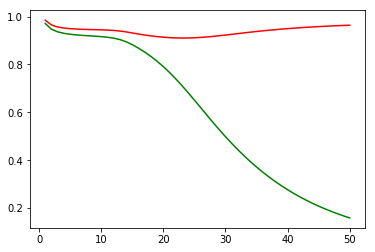

In [53]:
if __name__ == "__main__":
    train_matrix, test_matrix = loadData()
    model = SVD(train_matrix, test_matrix)
    model.train_and_evaluate()
    model.plot()